pretext tasks:
- shuffle the order of slices in sandwich, figure out correct slice order?

- jigsaw?

## Setup gdrive

In [1]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [5]:
%run "$PROJ_PATH/04_kspace_tfms.ipynb" # get the tfms to test

## Setup

In [ ]:
PROJ       = "fastmri"

# clone repo
!git clone https://github.com/RGologorsky/fastmri.git

# pip install/import
%run "$PROJ/common_constants_env.ipynb" # pip install fastai, fastmri, etc
%run "$PROJ/common_archs.ipynb"         # get simple cnn (stride 2 all the way)
%run "$PROJ/03_kspace_tfms.ipynb"       # get the kspace tfms

Cloning into 'fastmri'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (292/292), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 292 (delta 105), reused 173 (delta 45), pack-reused 0
Receiving objects: 100% (292/292), 18.44 MiB | 9.18 MiB/s, done.
Resolving deltas: 100% (105/105), done.
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [ ]:
%run "$PROJ/03_kspace_tfms.ipynb"       # get the kspace tfms

ERROR:root:File `'fastmri/03_kspace_tfms.ipynb.py'` not found.


# Real Data

1. Highres: MR image from **fully sampled ksapce**
2. Lowres: MR image from **undersampled kspace**

Get raw items. Raw items: list of (fname, attribute dict), derived from fn2attr.json stored in Gdrive. The attribute dict contains relevant info such as number of slices in the given h5 file.

In [6]:
from google.colab import drive
from pathlib      import Path
import json

# choose dataset
ds_name = "knee_singlecoil_val"
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

# Mount Google Drive 
ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

# Path to Proj
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ

# Load json containing attr info
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
fn2attr = json.load(path_json)
fn2attr_items = L(i for i in fn2attr.items())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # Sandwich Tfm

Given index, return sandwich at that index.

Setup/init: 
- pass a list of (fname, attribute_dict), each fname contains a kspace volume.
- pass $n_{seq}$, the desired sequence length. For example  n_seq=5 yields a kslice sequence of length 5, ($x$-2, $x$-1, $x$, $x$+1, $x$+2).

Encode: given index, 
- look up the correct file to open, 
- find the right slice sequence ($x$-2, $x$-1, $x$, $x$+1, $x$+2),
- return slice sequence and target slice $x$.

In [7]:
# indexes into array of kspace slices
class ToSandw(Transform):

  def __init__(self, fn2attr_items, n_seq = 5):
    self.fn2attr_items, self.n_seq = fn2attr_items, n_seq
    
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

  def encodes(self, sandw_idx):
    # get file
    fn_idx  = np.searchsorted(self.cumsum_n_sandws, sandw_idx)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    sw_idx   = sandw_idx - self.cumsum_n_sandws[fn_idx]
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as data:
      ksandw = data['kspace'][sw_idx:sw_idx+self.n_seq]      
      target = data['kspace'][sw_idx + self.n_seq//2]

    return T.to_tensor(ksandw), T.to_tensor(target)


In [43]:
# setup the transform
sandw_tfm = ToSandw(fn2attr_items, n_seq=5)
print(f"total #sandwiches = {sandw_tfm.total_n_sandws}")

# dataset = indices, sandw_tfm converts index to sandwich
raw_items = range(sandw_tfm.total_n_sandws)

# split between training/valid
splitter = RandomSplitter(valid_pct=0.2, seed=42)
high_res_splits = splitter(raw_items)
print(f"#train/#valid = {len(splits[0]), len(splits[1])}")

#splitter = GrandparentSplitter(valid_name="val")
#splitter = RandomSplitter(valid_pct=0.2, seed=42)

#tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()])
high_res_dset = TfmdLists(raw_items, tfms=[sandw_tfm], splits=high_res_splits)

total #sandwiches = 1196
#train/#valid = (957, 239)


In [10]:
# %run "$PROJ/04_kspace_tfms.ipynb"       # get the kspace tfms

k Sandwich                    : shape torch.Size([5, 640, 372, 2])
k Target slice                : shape torch.Size([640, 372, 2])
im magn Sandwich              : shape torch.Size([5, 640, 372])
k log magnitude Sandwich      : shape torch.Size([5, 640, 372])
im magn Target slice          : shape torch.Size([640, 372])
k log magnitude Target        : shape torch.Size([640, 372])


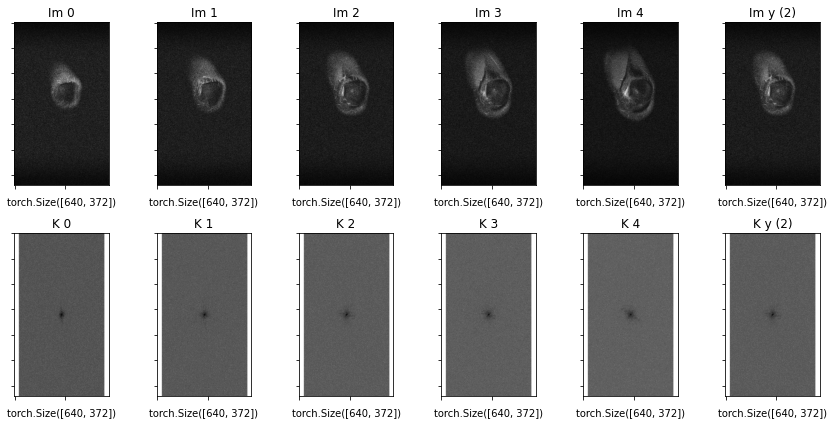

In [33]:
# viz dset
x,y = high_res_dset[0]
print(f"{'k Sandwich':30}: shape {x.shape}")
print(f"{'k Target slice':30}: shape {y.shape}")

# decode sandwich
rev_x = apply(x, CenteredTfms.k2im(), post=C.complex2mgn)
print(f"{'im magn Sandwich':30}: shape {rev_x.shape}")

# kspace abs sandwich
k_abs_x = apply(x, C.log, pre=C.complex2mgn)
print(f"{'k log magnitude Sandwich':30}: shape {k_abs_x.shape}")

# decodes target slice
rev_target = apply(y, CenteredTfms.k2im(), post=C.complex2mgn)
print(f"{'im magn Target slice':30}: shape {rev_target.shape}")

# kspace abs target slice
k_abs_target = apply(y, C.log, pre=C.complex2mgn)
print(f"{'k log magnitude Target':30}: shape {k_abs_target.shape}")

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

ims  = [rev_x[i]   for i in range(n_seq)] + [rev_target]
ims += [k_abs_x[i] for i in range(n_seq)] + [k_abs_target]

titles  = [f"Im {i}" for i in range(n_seq)] + [f"Im y ({n_seq//2})"]
titles += [f"K {i}"  for i in range(n_seq)] + [f"K y ({n_seq//2})"]

plot(ims, titles, nrows=2, ncols=n_seq+1, figsize=(12,6))

# Crappifier

Highres $\to$ Lowres 

(mask some lines in kspace)

In [26]:
from common.subsample import RandomMaskFunc

# Create a mask function
mask_func = RandomMaskFunc(center_fractions=[0.08, 0.04], accelerations=[4, 8])
# mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [27]:
T.apply_mask??

In [ ]:
def data_transform(kspace, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace)
    masked_kspace, _ = T.apply_mask(kspace, mask_func)
    return masked_kspace

In [28]:
T.apply_mask??

In [41]:
# indexes into array of kspace slices
class CrappifyTfm(ItemTransform):

  def __init__(self, center_frac=[0.08, 0.04], accel = [4,8], seed=42):
    self.center_fractions = center_frac
    self.accelerations    = accel
    self.seed             = seed

    self.mask_func = RandomMaskFunc(center_fractions=center_frac, accelerations=accel)    

  def encodes(self, o):
    ksandw, target = o
    return T.apply_mask(ksandw, mask_func = self.mask_func, seed=self.seed),target

# Dataset

1. input: undersampled kspace seq, $X_i = \{x_{i-2}, x_{i-1}, x_i, x_{i+1}, x_{i+2} \}$
2. target: fully sampled middle slice, $T_i$

In [ ]:
#  crappify_tfm masks fully-sampled kspace sandw, target unchanged
crappify_tfm = CrappifyTfm(center_frac=[0.08, 0.04], accel = [4,8], seed=42)

# dataset = indices, crappify_tfm converts index to sandwich
raw_items = high_res_dset

# split between training/valid
#low_res_splits = high_res_splits
splitter = RandomSplitter(valid_pct=0.2, seed=42)
low_res_splits = splitter(raw_items)
print(f"#train/#valid = {len(splits[0]), len(splits[1])}")

#splitter = GrandparentSplitter(valid_name="val")
#splitter = RandomSplitter(valid_pct=0.2, seed=42)

#tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()])
low_res_dset = TfmdLists(raw_items, tfms=[crappify_tfm], splits=low_res_splits)

#train/#valid = (957, 239)


In [38]:
# viz dset
x,y = low_res_dset[0]
print(f"{'k Sandwich':30}: shape {x.shape}")
print(f"{'k Target slice':30}: shape {y.shape}")

AttributeError: ignored

In [40]:
y

[tensor([[[[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          ...,
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]]],
 
 
         [[[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
          

In [36]:
# viz dset
x,y = low_res_dset[0]
print(f"{'k Sandwich':30}: shape {x.shape}")
print(f"{'k Target slice':30}: shape {y.shape}")

# decode sandwich
rev_x = apply(x, CenteredTfms.k2im(), post=C.complex2mgn)
print(f"{'im magn Sandwich':30}: shape {rev_x.shape}")

# kspace abs sandwich
k_abs_x = apply(x, C.log, pre=C.complex2mgn)
print(f"{'k log magnitude Sandwich':30}: shape {k_abs_x.shape}")

# decodes target slice
rev_target = apply(y, CenteredTfms.k2im(), post=C.complex2mgn)
print(f"{'im magn Target slice':30}: shape {rev_target.shape}")

# kspace abs target slice
k_abs_target = apply(y, C.log, pre=C.complex2mgn)
print(f"{'k log magnitude Target':30}: shape {k_abs_target.shape}")

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

ims  = [rev_x[i]   for i in range(n_seq)] + [rev_target]
ims += [k_abs_x[i] for i in range(n_seq)] + [k_abs_target]

titles  = [f"Im {i}" for i in range(n_seq)] + [f"Im y ({n_seq//2})"]
titles += [f"K {i}"  for i in range(n_seq)] + [f"K y ({n_seq//2})"]

plot(ims, titles, nrows=2, ncols=n_seq+1, figsize=(12,6))

AttributeError: ignored

In [ ]:
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on=None, blur:bool=False,
                 self_attention:bool=False, y_range=None, last_cross:bool=True,
                 bottle:bool=False, cut=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    
    # I have defined size intentionally like this, so that it won't be a problem when 
    # the input is an image 
    size = next(iter(data.train_dl))[0].shape[-2:]
    n_input_channels = next(iter(data.train_dl))[0][0].size(0)    
        
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    
    # changing the first layer to suit our input
    if not n_input_channels == 3: 
        prev_layer = body[0]
        body[0] = nn.Conv2d(n_input_channels, prev_layer.out_channels, 
                      kernel_size=prev_layer.kernel_size, 
                      stride=prev_layer.stride, 
                      padding=prev_layer.padding, 
                      bias=prev_layer.bias)

    model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained and n_input_channels == 3: 
        learn.freeze()
        apply_init(model[2], nn.init.kaiming_normal_)
    else: apply_init(model, nn.init.kaiming_normal_)
    return learn